In [56]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# 데이터 로드
der = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/der.csv")
der['datetime_beginning_ept'] = pd.to_datetime(der['datetime_beginning_ept'], format='%m/%d/%Y %I:%M:%S %p')

In [57]:
# 주요 변수 설정
I = list(range(0,15))  # DER 수
T = list(range(len(der.groupby(der['datetime_beginning_ept'].dt.hour).groups.keys())))  # 시간대 수 (24시간)
S = list(range(len(der.groupby(der['datetime_beginning_ept'].dt.date).groups.keys())))  # 날짜별 시나리오 인덱스

In [58]:
# 전일 시장 가격 (Day-ahead) 및 실시간 시장 가격 (Real-time)
# P_DA = {t: sum(der['system_energy_price_da'].iloc[t + s * len(T)] for s in S) / len(S) for t in T}
P_DA = {t: sum(der['system_energy_price_da'].iloc[t + s * len(T)] for s in S) / len(S) for t in T}
P_RT = {(t, s): der['system_energy_price_rt'].iloc[t + s * len(T)] for t in T for s in S}

# 패널티 비용 계산
P_PN = {(t, s): max(P_DA[t], P_RT[(t, s)]) * 2 for t in T for s in S}

# 시나리오 확률 계산
prob = {s: 1 / len(S) for s in S}

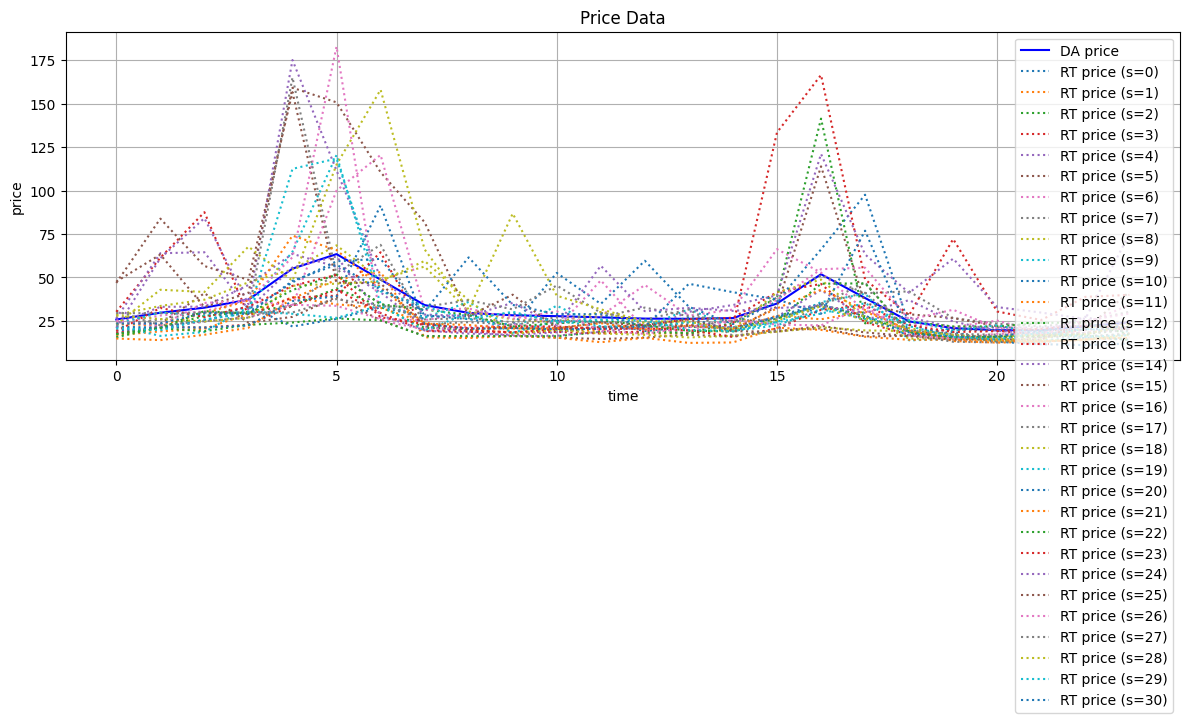

In [59]:
plt.figure(figsize=(12, 6))
plt.plot([t for t in T], [P_DA[t] for t in T], 'b-', label='DA price')

for s in S:
    plt.plot([t for t in T], [P_RT[t, s] for t in T], ':', label=f'RT price (s={s})')

# plt.plot([t for t in T], [P_PN[t,1] for t in T], 'g:', label='Penalty price (s=1)')
# plt.plot([t for t in T], [P_PN[t,2] for t in T], 'g-', label='Penalty price (s=2)')

plt.title('Price Data')
plt.xlabel('time')
plt.ylabel('price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [60]:
# DER 발전량 데이터 생성 (시간대 및 시나리오별 변동 포함)
np.random.seed(17)
R = {
    (i, t, s): max(
        0,
        10 + 3 * np.random.normal(0, 1)
    )
    for i in I for t in T for s in S
}

In [61]:
# ============================
# Case 1: DER only
# ============================
x_DA_1 = {(i, t): cp.Variable(pos=True) for i in I for t in T}
y_plus_1 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}
y_minus_1 = {(i, t, s): cp.Variable(pos=True) for i in I for t in T for s in S}

# Case 1 목적함수
obj_case1 = sum(
    P_DA[t] * x_DA_1[i, t] for i in I for t in T
) + sum(
    prob[s] * (P_RT[t, s] * y_plus_1[i, t, s] - P_PN[t, s] * y_minus_1[i, t, s])
    for i in I for t in T for s in S
)

# Case 1 제약조건
constraints_case1 = []
for i in I:
    for t in T:
        for s in S:
            constraints_case1.append(R[i, t, s] - x_DA_1[i, t] == y_plus_1[i, t, s] - y_minus_1[i, t, s])

# # y+와 y-의 동시 발생 방지
# M = 10000
# z_case1 = {(i, t, s): cp.Variable(boolean=True) for i in I for t in T for s in S}
# for i in I:
#     for t in T:
#         for s in S:
#             constraints_case1.append(y_plus_1[i, t, s] <= M * z_case1[i, t, s])
#             constraints_case1.append(y_minus_1[i, t, s] <= M * (1 - z_case1[i, t, s]))

In [62]:
# =========================
# 문제 정의 및 최적화 실행
# =========================
prob_case1 = cp.Problem(cp.Maximize(obj_case1), constraints_case1)

# 풀이 실행
prob_case1.solve(solver='GUROBI')

# 결과 출력
print("Case 1 최적해:")
print(f"총 이익: {prob_case1.value}")

c:\Users\symply_jina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "


Case 1 최적해:
총 이익: 113892.73668068332


In [63]:
# x, y+, y- 값을 출력하는 코드
for i in I:
    print(f"DER {i}:")
    for t in T:
        print(f"  x_DA_1: {x_DA_1[i,t].value}")
        for s in S:
            print(f"시간 {t}, 시나리오 {s}:")
            print(f"  R: {R[i,t,s]}")
            print(f"  y_plus_1: {y_plus_1[i,t,s].value}")
            print(f"  y_minus_1: {y_minus_1[i,t,s].value}")


DER 0:
  x_DA_1: 4.543562982091513
시간 0, 시나리오 0:
  R: 10.828797670063956
  y_plus_1: 6.2852346879724434
  y_minus_1: 0.0
시간 0, 시나리오 1:
  R: 4.436115763580485
  y_plus_1: 0.0
  y_minus_1: 0.10744721851102756
시간 0, 시나리오 2:
  R: 11.871703333979069
  y_plus_1: 7.328140351887556
  y_minus_1: 0.0
시간 0, 시나리오 3:
  R: 13.43593386871627
  y_plus_1: 8.892370886624757
  y_minus_1: 0.0
시간 0, 시나리오 4:
  R: 13.111571404683648
  y_plus_1: 8.568008422592136
  y_minus_1: 0.0
시간 0, 시나리오 5:
  R: 15.659916789344823
  y_plus_1: 11.116353807253311
  y_minus_1: 0.0
시간 0, 시나리오 6:
  R: 9.664905129613702
  y_plus_1: 5.121342147522189
  y_minus_1: 0.0
시간 0, 시나리오 7:
  R: 8.913695984802855
  y_plus_1: 4.370133002711342
  y_minus_1: 0.0
시간 0, 시나리오 8:
  R: 10.446025135135732
  y_plus_1: 5.90246215304422
  y_minus_1: 0.0
시간 0, 시나리오 9:
  R: 8.686650542456103
  y_plus_1: 4.143087560364591
  y_minus_1: 0.0
시간 0, 시나리오 10:
  R: 16.51377099251993
  y_plus_1: 11.970208010428419
  y_minus_1: 0.0
시간 0, 시나리오 11:
  R: 13.45693075

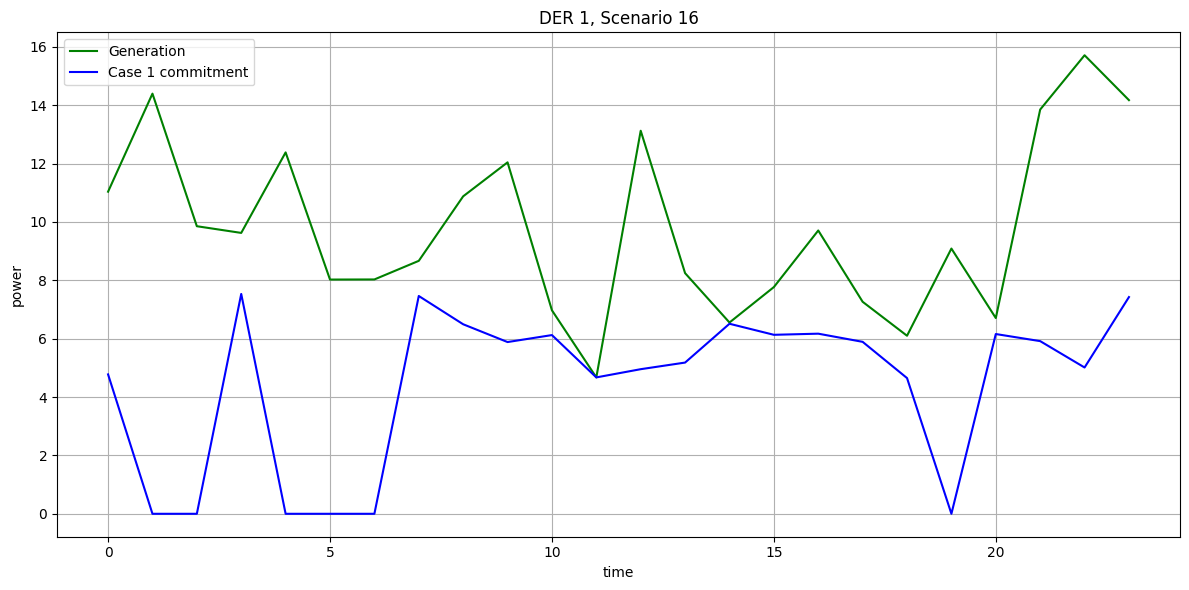

In [64]:
plt.figure(figsize=(12, 6))

i, s = 1, 16
plt.plot([t for t in T], [R[i,t,s] for t in T], 'g-', label='Generation')
plt.plot([t for t in T], [x_DA_1[i,t].value for t in T], 'b-', label='Case 1 commitment')
# plt.plot([t for t in T], [y_plus_1[i,t,s].value for t in T], 'b:', label='Case 1 y+')

plt.title(f'DER {i}, Scenario {s}')
plt.xlabel('time')
plt.ylabel('power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
# i별 평균 commitment 계산
print("\n각 DER별 하루 평균 commitment 분석:")
for i in I:
    # Case 1 평균값 계산
    case1_commitment = sum(x_DA_1[i,t].value for t in T)

    print(f"\nDER {i}:")
    print(f"  Case 1 평균 commitment: {case1_commitment:.2f} MW")


각 DER별 하루 평균 commitment 분석:

DER 0:
  Case 1 평균 commitment: 101.04 MW

DER 1:
  Case 1 평균 commitment: 106.97 MW

DER 2:
  Case 1 평균 commitment: 102.71 MW

DER 3:
  Case 1 평균 commitment: 100.54 MW

DER 4:
  Case 1 평균 commitment: 100.02 MW

DER 5:
  Case 1 평균 commitment: 103.76 MW

DER 6:
  Case 1 평균 commitment: 96.50 MW

DER 7:
  Case 1 평균 commitment: 105.26 MW

DER 8:
  Case 1 평균 commitment: 105.44 MW

DER 9:
  Case 1 평균 commitment: 99.68 MW

DER 10:
  Case 1 평균 commitment: 96.40 MW

DER 11:
  Case 1 평균 commitment: 105.11 MW

DER 12:
  Case 1 평균 commitment: 102.50 MW

DER 13:
  Case 1 평균 commitment: 97.92 MW

DER 14:
  Case 1 평균 commitment: 104.02 MW


In [66]:
# i별 평균 profit 계산
print("\n각 DER별 하루 평균 profit 분석:")
for i in I:
    # Case 1 profit 계산
    case1_profit = sum(
        P_DA[t] * x_DA_1[i,t] for t in T
    ) + sum(
        prob[s] * (P_RT[t, s] * y_plus_1[i,t,s] - P_PN[t, s] * y_minus_1[i,t,s])
        for t in T for s in S
    )
    
    print(f"\nDER {i}:")
    for t in T:
        print(f"  시간 {t}:")
        print(f"    P_DA: {P_DA[t]:.2f} (x_DA_1: {x_DA_1[i,t].value:.2f})")
        for s in S:
            print(f"    시나리오 {s}:")
            print(f"      R: {R[i,t,s]:.2f}")
            print(f"      P_RT: {prob[s] * P_RT[t, s]:.2f} (y_plus_1: {y_plus_1[i,t,s].value:.2f})")
            print(f"      P_PN: {prob[s] * P_PN[t, s]:.2f} (y_minus_1: {y_minus_1[i,t,s].value:.2f})")
        # 각 시간별 profit 계산 및 출력
        time_profit = P_DA[t] * x_DA_1[i,t].value + sum(prob[s] * (P_RT[t, s] * y_plus_1[i,t,s].value - P_PN[t, s] * y_minus_1[i,t,s].value) for s in S)
        print(f"    시간 {t}의 profit: {time_profit:.2f}")
    print(f"  DER {i}의 Case 1 평균 profit: {case1_profit.value:.2f}")



각 DER별 하루 평균 profit 분석:

DER 0:
  시간 0:
    P_DA: 25.81 (x_DA_1: 4.54)
    시나리오 0:
      R: 10.83
      P_RT: 0.58 (y_plus_1: 6.29)
      P_PN: 1.66 (y_minus_1: 0.00)
    시나리오 1:
      R: 4.44
      P_RT: 0.54 (y_plus_1: 0.00)
      P_PN: 1.66 (y_minus_1: 0.11)
    시나리오 2:
      R: 11.87
      P_RT: 0.50 (y_plus_1: 7.33)
      P_PN: 1.66 (y_minus_1: 0.00)
    시나리오 3:
      R: 13.44
      P_RT: 0.58 (y_plus_1: 8.89)
      P_PN: 1.66 (y_minus_1: 0.00)
    시나리오 4:
      R: 13.11
      P_RT: 0.74 (y_plus_1: 8.57)
      P_PN: 1.66 (y_minus_1: 0.00)
    시나리오 5:
      R: 15.66
      P_RT: 0.80 (y_plus_1: 11.12)
      P_PN: 1.66 (y_minus_1: 0.00)
    시나리오 6:
      R: 9.66
      P_RT: 0.82 (y_plus_1: 5.12)
      P_PN: 1.66 (y_minus_1: 0.00)
    시나리오 7:
      R: 8.91
      P_RT: 0.99 (y_plus_1: 4.37)
      P_PN: 1.98 (y_minus_1: 0.00)
    시나리오 8:
      R: 10.45
      P_RT: 0.92 (y_plus_1: 5.90)
      P_PN: 1.84 (y_minus_1: 0.00)
    시나리오 9:
      R: 8.69
      P_RT: 0.72 (y_plus_1: 4.14)
      

In [67]:
# 모든 der의 profit 합계 계산
total_der_profit = 0
for i in I:
    # 각 der i의 profit 합계 계산
    der_profit = sum(P_DA[t] * x_DA_1[i,t].value + sum(prob[s] * (P_RT[t,s] * y_plus_1[i,t,s].value - P_PN[t,s] * y_minus_1[i,t,s].value) for s in S) for t in T)
    total_der_profit += der_profit
    print(i, der_profit)

print(f"\n모든 der의 profit 합계: {total_der_profit:.2f}")


0 7588.30215355001
1 7588.883346127197
2 7899.696025281602
3 7604.860754086443
4 7546.7624660053125
5 7844.544133642999
6 7533.816752643708
7 7566.446356830723
8 7510.931066760687
9 7373.080521122422
10 7569.397353792093
11 7533.977627714616
12 7569.401022026044
13 7468.645684176496
14 7693.991416922747

모든 der의 profit 합계: 113892.74


In [68]:
i=5
total_der_profit = 0
for t in T:
    der_profit = P_DA[t] * x_DA_1[i,t].value + sum(prob[s] * (P_RT[t,s] * y_plus_1[i,t,s].value - P_PN[t,s] * y_minus_1[i,t,s].value) for s in S)
    total_der_profit += der_profit
    print(f"시간 {t}의 profit: {der_profit:.2f}")
    print(f"시간 {t}의 x: {x_DA_1[i,t].value:.2f}")
    print(f"시간 {t}의 y+: {sum(y_plus_1[i,t,s].value for s in S):.2f}")
    print(f"시간 {t}의 y-: {sum(y_minus_1[i,t,s].value for s in S):.2f}")
print(f"DER {i}의 총 profit: {total_der_profit:.2f}")

시간 0의 profit: 257.17
시간 0의 x: 4.53
시간 0의 y+: 186.62
시간 0의 y-: 1.96
시간 1의 profit: 319.74
시간 1의 x: 0.00
시간 1의 y+: 314.04
시간 1의 y-: 0.00
시간 2의 profit: 347.04
시간 2의 x: 0.00
시간 2의 y+: 316.14
시간 2의 y-: 0.00
시간 3의 profit: 374.60
시간 3의 x: 7.65
시간 3의 y+: 94.09
시간 3의 y-: 4.18
시간 4의 profit: 609.40
시간 4의 x: 0.00
시간 4의 y+: 322.21
시간 4의 y-: 0.00
시간 5의 profit: 733.87
시간 5의 x: 0.00
시간 5의 y+: 352.90
시간 5의 y-: 0.00
시간 6의 profit: 534.31
시간 6의 x: 0.00
시간 6의 y+: 328.81
시간 6의 y-: 0.00
시간 7의 profit: 319.58
시간 7의 x: 7.24
시간 7의 y+: 82.10
시간 7의 y-: 2.01
시간 8의 profit: 283.50
시간 8의 x: 7.03
시간 8의 y+: 100.41
시간 8의 y-: 2.74
시간 9의 profit: 267.95
시간 9의 x: 5.33
시간 9의 y+: 138.52
시간 9의 y-: 3.11
시간 10의 profit: 257.30
시간 10의 x: 6.95
시간 10의 y+: 91.46
시간 10의 y-: 4.37
시간 11의 profit: 245.28
시간 11의 x: 5.01
시간 11의 y+: 132.20
시간 11의 y-: 1.66
시간 12의 profit: 264.52
시간 12의 x: 7.06
시간 12의 y+: 117.12
시간 12의 y-: 4.78
시간 13의 profit: 244.52
시간 13의 x: 4.77
시간 13의 y+: 146.75
시간 13의 y-: 0.69
시간 14의 profit: 237.93
시간 14의 x: 5.87
시간 14의 y+: 1

In [69]:
# 목적함수값 출력 코드
print(f"목적함수값: {prob_case1.value:.2f}")

목적함수값: 113892.74


In [70]:
# Case 1과 Case 2의 총 profit 검증
print("\n총 Profit 검증:")

# Case 1 총 profit 계산 (i별 평균 profit의 합)
case1_total_profit = sum(
    (sum(P_DA[t] * x_DA_1[i,t] for t in T) + 
    sum(prob[s] * (P_RT[t,s] * y_plus_1[i,t,s] - P_PN[t,s] * y_minus_1[i,t,s])
        for t in T for s in S)).value
    for i in I
)


print(f"\nCase 1:")
print(f"  개별 DER profit 합계: {case1_total_profit:.2f}")
print(f"  목적함수 값: {prob_case1.value:.2f}")
print(f"  차이: {abs(case1_total_profit - prob_case1.value):.10f}")



총 Profit 검증:

Case 1:
  개별 DER profit 합계: 113892.74
  목적함수 값: 113892.74
  차이: 0.0000000002
